<h1>Final Capstone Project </h1>

<h3>Import required libraries</h3>

In [1]:
#!pip install --upgrade requests branca six jinja2 numpy chardet idna urllib3 certifi MarkupSafe
!conda install -c conda-forge folium --yes
!conda install -c conda-forge geopy --yes
!conda install -c conda-forge wordcloud==1.4.1 --yes
import numpy as np
import pandas as pd
import requests
import random
from sklearn.cluster import KMeans
from pandas.io.json import json_normalize
import folium
from folium.plugins import MiniMap
from geopy.geocoders import Nominatim
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn import metrics
from PIL import Image
import matplotlib.patches as mpatches
from wordcloud import WordCloud, get_single_color_func
print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    openssl-1.1.1f             |       h516909a_0         2.1 MB  conda-forge
    folium-0.10.1              |             py_0          59 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTAL

<h3>downloading and loading Newyork dataset </h3>

In [4]:
!wget -q -O 'newyork_data.json' https://ibm.box.com/shared/static/fbpwbovar7lf8p5sgddm06cgipa2rxpe.json
print('Data downloaded!')
print('Loading data...')
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
print('\n...data loaded succesfully!')

Data downloaded!
Loading data...

...data loaded succesfully!


<h3>viewing data in pandas dataframe </h3>

In [5]:
neighborhoods_ny = pd.DataFrame(columns = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'])
for data in newyork_data['features']:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods_ny = neighborhoods_ny.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

#Take only neighborhoods from manhattan!
neighborhoods_ny = neighborhoods_ny[neighborhoods_ny['Borough'] == 'Manhattan'].reset_index(drop=True)
neighborhoods_ny.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [6]:
print("{} neighborhoods found in New York city.".format(neighborhoods_ny.shape[0]))

40 neighborhoods found in New York city.


<h3>downloding and loading Toronto dataset</h3>

In [9]:
webPage = requests.get("https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&direction=next&oldid=942655364")
print('Data downloaded!')
print('Loading data...')
html = webPage.text                                                                       
tableInit = html.find('<table class="wikitable sortable">')                            
tableFinal = html.find('</table>')                                                      
htmlTable = html[tableInit:tableFinal]
print('\n...data loaded succesfully!')

Data downloaded!
Loading data...

...data loaded succesfully!


<h3>viewing data in pandas data frame </h3>

In [10]:
table = pd.read_html(htmlTable, header = 0)[0]                                            
table["Borough"] = table["Borough"].replace({"Not assigned":np.nan})                
table.dropna(inplace = True)                                                          
table.where(table != "Not assigned", table["Borough"], axis = 0, inplace = True)      
joinedRows = table.groupby("Postcode")["Neighbourhood"].apply(lambda x: ", ".join(x)) 
table.drop_duplicates(["Postcode"],inplace = True)                                    
df = table.join(joinedRows, on = "Postcode", lsuffix='_single')                       
df.drop(columns = ["Neighbourhood_single"], inplace = True)                         
df.reset_index(drop = True, inplace = True)

In [11]:
!wget -q -O 'Geospatial_Coordinates.csv' http://cocl.us/Geospatial_data
geo = pd.read_csv("Geospatial_Coordinates.csv", index_col = 0)         
neighborhoods_to = df.join(geo, on = "Postcode")

#Take only those neighborhoods that contain the word Toronto
neighborhoods_to = neighborhoods_to[neighborhoods_to['Borough'].str.contains('Toronto')].reset_index(drop=True)
neighborhoods_to.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
1,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494
2,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [12]:
print("\n{} neighborhoods found in the city of Toronto.".format(neighborhoods_to.shape[0]))



39 neighborhoods found in the city of Toronto.


<h3>visualize neighborhoods in Newyork and Toronto </h3>

In [13]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
ny_latitude = location.latitude
ny_longitude = location.longitude
print('The geograpical coordinate of New York City (Manhattan) are {}, {}.'.format(ny_latitude, ny_longitude))

address = 'Toronto'

location = geolocator.geocode(address)
to_latitude = location.latitude
to_longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(to_latitude, to_longitude))

centerLatitude = (ny_latitude + to_latitude)/2
centerLongitude = (ny_longitude + to_longitude)/2

print('\nThe geograpical central coordinates are {}, {}.'.format(centerLatitude, centerLongitude))

The geograpical coordinate of New York City (Manhattan) are 40.7896239, -73.9598939.
The geograpical coordinate of Toronto are 43.6534817, -79.3839347.

The geograpical central coordinates are 42.2215528, -76.6719143.


In [14]:
tmp = neighborhoods_to.drop("Postcode",axis = 1)
tmp.rename(columns = {"Neighbourhood":"Neighborhood"}, inplace = True)
df = neighborhoods_ny.append(tmp, True).reset_index(drop = True)
pd.set_option('max_rows', 6)
df

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
...,...,...,...,...
76,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280
77,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
78,East Toronto,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558


<h3>Visualize neighborhoods in a map </h3>

In [15]:
map_tony = folium.Map(location=[centerLatitude, centerLongitude], zoom_start=7, width='100%', height='100%')

for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_tony)
map_tony

<h4>map newyork <h4>

In [16]:
map_tony = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=11, width='100%', height='100%')

for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_tony)

minimap = MiniMap(position = 'topleft', center_fixed = (ny_latitude, ny_longitude), zoom_level_fixed = 8)
minimap.add_to(map_tony)

minimap = MiniMap(position='bottomright',  center_fixed = (to_latitude, to_longitude), zoom_level_fixed = 8)
minimap.add_to(map_tony)
map_tony

<h4>map in Toronto </h4>

In [18]:
map_tony = folium.Map(location=[to_latitude, to_longitude], zoom_start=11, width='100%', height='100%')

for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_tony)
    minimap = MiniMap(position = 'topleft', center_fixed = (ny_latitude, ny_longitude), zoom_level_fixed = 8)
minimap.add_to(map_tony)

minimap = MiniMap(position='bottomright',  center_fixed = (to_latitude, to_longitude), zoom_level_fixed = 8)
minimap.add_to(map_tony)
map_tony

<h3>Importing data from foursquare </h3>

In [ ]:
CLIENT_ID = '2I0S3UDT4JPCUVSECPX2NUVA1DCGMOJCICB5PMJJIVQNMXHV' # your Foursquare ID
CLIENT_SECRET = 'HR1NF5MW52YXVDV0KWI5G3XFVWXFRHRNOBYRQEUCGKXA10CL' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

In [ ]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def getNearbyVenues(names, boroughs, latitudes, longitudes, radius=500):
    ind = 1
    venues_list=[]
    for name, borough, lat, lng in zip(names, boroughs, latitudes, longitudes):
        tmp=[]
        print(color.BOLD+str(ind)+" | "+name+color.END)
        ind += 1
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        #tmp.append([(j['venue']['name']) for j in results])
        #for item in tmp[0]:
        #    print("\t",item)
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            borough,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                  'Borough',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    print("\nDone!")
    return(nearby_venues)

In [21]:
tony_venues = getNearbyVenues(names=df['Neighborhood'],
                                   boroughs = df['Borough'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

16 | Midtown
17 | Murray Hill
18 | Chelsea
19 | Greenwich Village
20 | East Village
21 | Lower East Side
22 | Tribeca
23 | Little Italy
24 | Soho
25 | West Village
26 | Manhattan Valley
27 | Morningside Heights
28 | Gramercy
29 | Battery Park City
30 | Financial District
31 | Carnegie Hill
32 | Noho
33 | Civic Center
34 | Midtown South
35 | Sutton Place
36 | Turtle Bay
37 | Tudor City
38 | Stuyvesant Town
39 | Flatiron
40 | Hudson Yards
41 | Harbourfront
42 | Queen's Park
43 | Ryerson, Garden District
44 | St. James Town
45 | The Beaches
46 | Berczy Park
47 | Central Bay Street
48 | Christie
49 | Adelaide, King, Richmond
50 | Dovercourt Village, Dufferin
51 | Harbourfront East, Toronto Islands, Union Station
52 | Little Portugal, Trinity
53 | The Danforth West, Riverdale
54 | Design Exchange, Toronto Dominion Centre
55 | Brockton, Exhibition Place, Parkdale Village
56 | The Beaches West, India Bazaar
57 | Commerce Court, Victoria Hotel
58 | Studio District
59 | Lawrence Park
60 | Rosel

<h3>Onehot encoding and grouping by neighborhoods</h3>

In [23]:
# one hot encoding
tony_onehot = pd.get_dummies(tony_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
tony_onehot['Neighborhood'] = tony_venues['Neighborhood'] 
tony_onehot['Borough'] = tony_venues['Borough']
tony_onehot['Neighborhood Latitude'] = tony_venues['Neighborhood Latitude']
tony_onehot['Neighborhood Longitude'] = tony_venues['Neighborhood Longitude']


# move neighborhood column to the first column
fixed_columns = [tony_onehot.columns[-1]] + list(tony_onehot.columns[:-1])
tony_onehot = tony_onehot[fixed_columns]

tony_grouped = tony_onehot.groupby(['Neighborhood','Borough','Neighborhood Latitude','Neighborhood Longitude']).mean().reset_index()

#print(tony_venues.drop_duplicates(["Neighborhood"],inplace = False)['Neighborhood'].reset_index(drop=True))    
tony_grouped

,Neighborhood,Borough,Neighborhood Latitude,Neighborhood Longitude,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,...,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",Downtown Toronto,43.650571,-79.384568,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.000000,0.000000,0.00,0.010638,0.0
1,Battery Park City,Manhattan,40.711932,-74.016869,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.000000,0.033898,0.00,0.000000,0.0
2,Berczy Park,Downtown Toronto,43.644771,-79.373306,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,Washington Heights,Manhattan,40.851903,-73.936900,0.011236,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.011236,0.022472,0.00,0.011236,0.0
77,West Village,Manhattan,40.734434,-74.006180,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.080000,0.000000,0.00,0.000000,0.0
78,Yorkville,Manhattan,40.775930,-73.947118,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.01,0.02,0.0,0.0,0.0,0.010000,0.030000,0.01,0.000000,0.0


<h3>K means clustering </h3>

<h4> finding best k </h4>

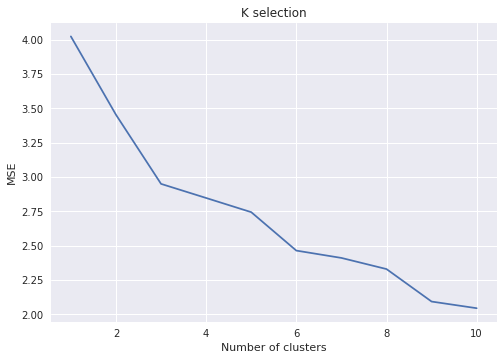

In [25]:
# Finding best k
plt.style.use("seaborn")
Ks = 11
mse = np.zeros((Ks-1))
tony_grouped_clustering = tony_grouped.drop(['Neighborhood','Borough','Neighborhood Latitude','Neighborhood Longitude'], 1)
for n in range(1,Ks):
    
    # set number of clusters
    kclusters = n
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0, init = 'random', n_init = 15).fit(tony_grouped_clustering)
    mse[n-1] = kmeans.inertia_

plt.plot(range(1,Ks),mse)
plt.xlabel("Number of clusters")
plt.ylabel("MSE")
plt.title("K selection")
plt.show()

<h5>five clusers select for finding simillarities</h5>

In [26]:
kclusters = 5
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0, init = 'random', n_init = 15).fit(tony_grouped_clustering)
    
tony_merged = df

# add clustering labels
tony_merged['Cluster Labels'] = kmeans.labels_

tony_merged

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels
0,Manhattan,Marble Hill,40.876551,-73.910660,2
1,Manhattan,Chinatown,40.715618,-73.994279,2
2,Manhattan,Washington Heights,40.851903,-73.936900,2
...,...,...,...,...,...
76,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280,3
77,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,2
78,East Toronto,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558,3


<h3>Display clusters in maps </h3>

In [27]:
# create map
map_clusters = folium.Map(location=[centerLatitude, centerLongitude], zoom_start=7, width='100%', height='100%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tony_merged['Latitude'], tony_merged['Longitude'], tony_merged['Neighborhood'], tony_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [28]:
map_clusters = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=11, width='100%', height='100%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tony_merged['Latitude'], tony_merged['Longitude'], tony_merged['Neighborhood'], tony_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       


minimap = MiniMap(position = 'topleft', center_fixed = (ny_latitude, ny_longitude), zoom_level_fixed = 8)
minimap.add_to(map_clusters)

minimap = MiniMap(position='bottomright',  center_fixed = (to_latitude, to_longitude), zoom_level_fixed = 8)
minimap.add_to(map_clusters)
map_clusters

<h3> Analyze centroids <h3>

<h5> cluster one </h5>

In [30]:
cl1 = tony_merged.loc[tony_merged['Cluster Labels'] == 0, tony_merged.columns[[1] + list(range(5, tony_merged.shape[1]))]]
cl1

,Neighborhood
58,Lawrence Park


<h5>cluster two </h5>

In [31]:
cl2 = tony_merged.loc[tony_merged['Cluster Labels'] == 1, tony_merged.columns[[1] + list(range(5, tony_merged.shape[1]))]]
cl2

,Neighborhood
38,Flatiron
49,"Dovercourt Village, Dufferin"
57,Studio District


<h5>cluster three </h5>

In [32]:
pd.set_option('max_rows', 100)
cl3 = tony_merged.loc[tony_merged['Cluster Labels'] == 2, tony_merged.columns[[1] + list(range(5, tony_merged.shape[1]))]]
cl3

,Neighborhood
0,Marble Hill
1,Chinatown
2,Washington Heights
3,Inwood
7,East Harlem
8,Upper East Side
10,Lenox Hill
12,Upper West Side
13,Lincoln Square
14,Clinton


<h5>cluster four </h5>

In [33]:
cl4 = tony_merged.loc[tony_merged['Cluster Labels'] == 3, tony_merged.columns[[1] + list(range(5, tony_merged.shape[1]))]]
cl4

,Neighborhood
4,Hamilton Heights
6,Central Harlem
9,Yorkville
11,Roosevelt Island
16,Murray Hill
18,Greenwich Village
20,Lower East Side
22,Little Italy
23,Soho
24,West Village


<h5>cluster five </h5>

In [ ]:
cl5 = tony_merged.loc[tony_merged['Cluster Labels'] == 4, tony_merged.columns[[1] + list(range(5, tony_merged.shape[1]))]]
cl5